## 프로젝트 배경
- 판단근거 없이 무작위로 Push를 보내게 된다면 고객에게는 의미없는 단순 알림일 뿐이기 때문에 개인화된 알림을 통해 고객 별로 구매가 이뤄질 시간을 예상해보고자 함.

## 프로젝트 목적
- 사용자별로 소비의 패턴이 다를 수 있음을 고려하여 가장 많이 구매한 시간대를 찾아 해당 시간대에 쿠폰을 발송하면 매출의 증대로 이어질 것

## 프로젝트 방법
- 사용자 별로 최대 주문 시간을 계산하여 최적의 Push 시간대를 도출
- 현 데이터로는 가장 많이 주문이 일어나는 시점에서 하는 것이 가장 직관적인 판단
- 과정
    1. 데이터 파악
    2. 가설제시
    3. 가설 검증
    4. 1~3 반복

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
COLORS = sns.color_palette()
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
dtypes = {
    'UnitPrice':np.float32,
    'CustomerID':np.int32,
    'Qunaity':np.int32}

In [ ]:
retail = pd.read_csv('./data/OnlineRetailClean.csv', dtype=dtypes)
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],
                                       infer_datetime_format=True)

In [9]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [10]:
def plot_bar(df, xlabel, ylabel, title,color = COLORS[0], figsize=(20,10), rotation=45):
    plot = df.plot(kind='bar',color=color, figsize=figsize)
    plot.set_xlabel(xlabel,fontsize=11)
    plot.set_ylabel(ylabel,fontsize=11)
    plot.set_title(title, fontsize=13)
    plot.set_xticklabels(labels=df.index, rotation=rotation)

In [11]:
order_by_hour = retail.set_index('InvoiceDate').groupby(lambda date: date.hour).count()['CustomerID']
order_by_hour

6         1
7       379
8      8690
9     21944
10    37997
11    49084
12    72065
13    64026
14    54118
15    45369
16    24089
17    13071
18     2928
19     3321
20      802
Name: CustomerID, dtype: int64

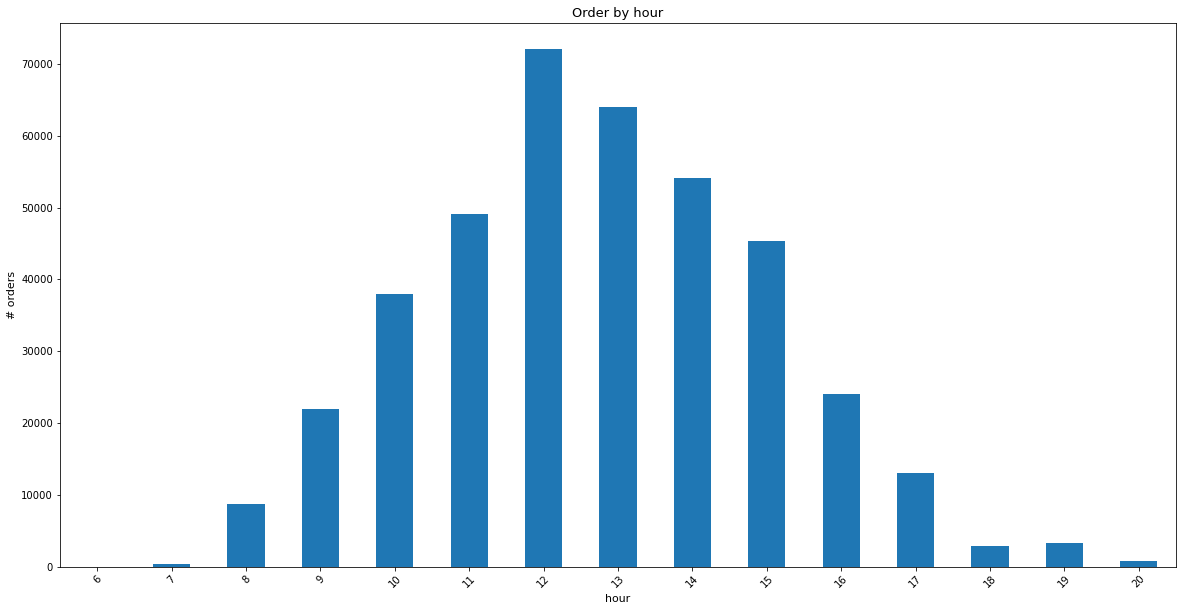

In [12]:
plot_bar(order_by_hour,'hour','# orders','Order by hour')

- 12시 까지 증가세를 보이다가 1시부터 감소세
- 12시 전후로 푸쉬 보내보기
- 세그룹으로 나눠서 실험

In [13]:
def half_an_hour(date):
    minute = ':00'
    if date.minute > 30:
        minute = ':30'
    
    hour = str(date.hour)
    if date.hour < 10:
        hour = '0' + hour
    return hour + minute

In [14]:
order_by_hour_half = retail.set_index('InvoiceDate').groupby(half_an_hour).count()['CustomerID']
order_by_hour_half

06:00        1
07:30      379
08:00     3145
08:30     5545
09:00     9364
09:30    12580
10:00    16950
10:30    21047
11:00    18925
11:30    30159
12:00    37174
12:30    34891
13:00    31131
13:30    32895
14:00    26958
14:30    27160
15:00    24227
15:30    21142
16:00    14316
16:30     9773
17:00     8889
17:30     4182
18:00     1715
18:30     1213
19:00     1534
19:30     1787
20:00      802
Name: CustomerID, dtype: int64

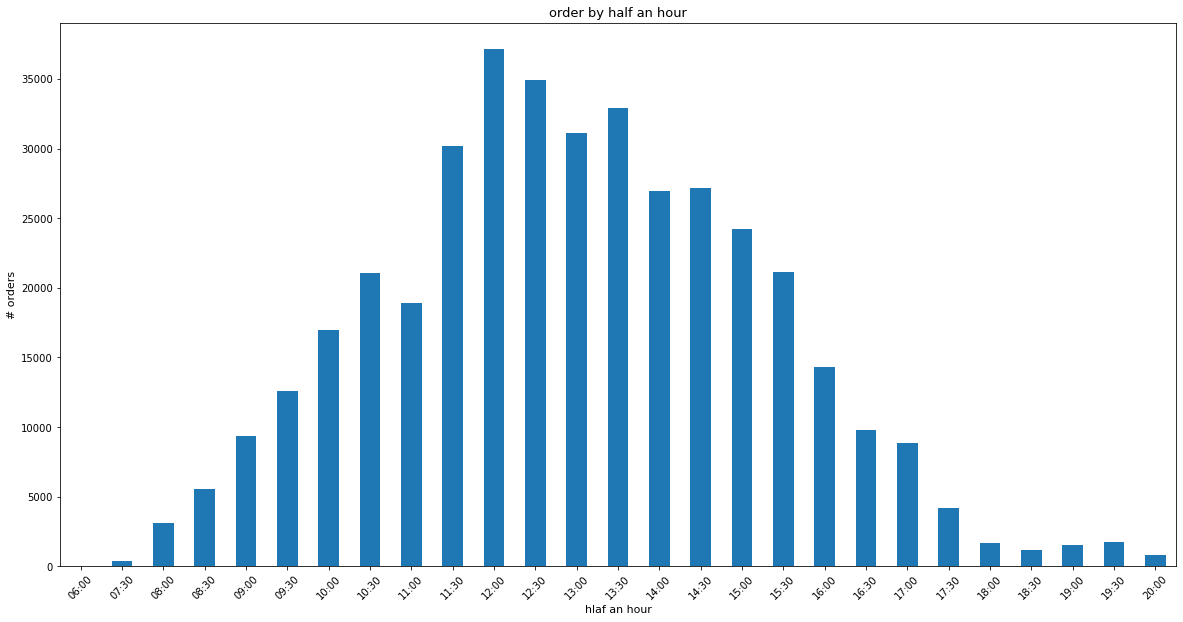

In [15]:
plot_bar(order_by_hour_half,'hlaf an hour','# orders','order by half an hour')

In [16]:
order_by_hour_half / order_by_hour_half.sum()

06:00    0.000003
07:30    0.000953
08:00    0.007904
08:30    0.013936
09:00    0.023534
09:30    0.031617
10:00    0.042600
10:30    0.052897
11:00    0.047564
11:30    0.075798
12:00    0.093429
12:30    0.087691
13:00    0.078241
13:30    0.082675
14:00    0.067753
14:30    0.068261
15:00    0.060890
15:30    0.053136
16:00    0.035980
16:30    0.024562
17:00    0.022341
17:30    0.010511
18:00    0.004310
18:30    0.003049
19:00    0.003855
19:30    0.004491
20:00    0.002016
Name: CustomerID, dtype: float64

#### 사용자별 각 시간별 주문량 계산하기

In [17]:
order_count_by_hour = retail.set_index('InvoiceDate').groupby(['CustomerID',lambda date:date.hour]).count()['StockCode']
order_count_by_hour

CustomerID    
12346       10     1
12347       8     22
            10    24
            12    47
            13    18
                  ..
18283       15     1
            16    56
            19    87
18287       9      3
            10    67
Name: StockCode, Length: 11205, dtype: int64

#### 사용자별 최대 주문 시간 계산하기
- 가장 많은 주문량을 보인 시간을 계산

In [18]:
order_count_by_hour.loc[12347]

8     22
10    24
12    47
13    18
14    60
15    11
Name: StockCode, dtype: int64

#### 사용자별 최대 주문 시간 계산하기
- 가장 많은 주문량을 보인 시간을 계산

In [20]:
idx = order_count_by_hour.groupby('CustomerID').idxmax()

#### 해당 시간 indexing

In [22]:
result = order_count_by_hour.loc[idx]
result

CustomerID    
12346       10      1
12347       14     60
12348       19     17
12349       9      73
12350       16     17
                 ... 
18280       9      10
18281       10      7
18282       13      7
18283       14    201
18287       10     67
Name: StockCode, Length: 4338, dtype: int64

In [24]:
result.reset_index().groupby('level_1').groups

{7: [73, 269, 319, 344, 375, 893, 1667, 2317], 8: [46, 58, 87, 126, 172, 179, 187, 260, 278, 279, 282, 292, 306, 347, 399, 429, 496, 503, 526, 533, 549, 552, 651, 671, 747, 755, 784, 792, 800, 803, 806, 821, 838, 877, 883, 920, 944, 947, 951, 954, 1008, 1093, 1106, 1120, 1138, 1172, 1173, 1217, 1251, 1397, 1422, 1424, 1436, 1472, 1512, 1616, 1621, 1666, 1668, 1678, 1687, 1734, 1759, 1761, 1774, 1791, 1815, 1827, 1846, 1859, 1895, 1900, 1903, 1996, 2018, 2023, 2054, 2085, 2108, 2117, 2167, 2172, 2253, 2380, 2383, 2403, 2404, 2417, 2427, 2462, 2464, 2643, 2749, 2776, 2781, 2896, 2936, 2949, 3021, 3130, ...], 9: [3, 9, 26, 30, 33, 35, 37, 48, 60, 66, 75, 84, 86, 90, 100, 106, 107, 121, 127, 135, 138, 142, 144, 146, 154, 159, 181, 199, 230, 240, 264, 265, 267, 277, 280, 286, 294, 298, 328, 333, 336, 342, 343, 352, 362, 366, 385, 402, 421, 459, 470, 475, 478, 482, 483, 509, 517, 519, 574, 603, 615, 630, 636, 642, 644, 691, 701, 706, 707, 746, 749, 752, 764, 770, 781, 783, 818, 825, 829, 844